### Stock Price Prediction using Amazon Stock Dataset

Dataset is from $\href{https://www.kaggle.com/datasets/muhammaddawood42/amazon-stock-data/data}{Kaggle Website}$

In [1]:
import pandas as pd

file_path = "/kaggle/input/amazon-stock-data/Amazon_Stock_Data.csv"

df = pd.read_csv(file_path)

df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-02,15.425999641418457,15.425999641418457,15.737500190734863,15.347999572753906,15.628999710083008,55664000
3,2015-01-05,15.10949993133545,15.10949993133545,15.418999671936035,15.042499542236328,15.350500106811523,55484000
4,2015-01-06,14.76449966430664,14.76449966430664,15.149999618530273,14.619000434875488,15.112000465393066,70380000


Accessing the raw dataset, we can see $7$ columns:

- $\textbf{Price}:$ Metadata column, requiring further preprocessing (cleaning)
- $\textbf{Adj Close}:$ Adjusted closing stock price, reflecting corporate actions like stock splits and dividends
- $\textbf{Close}:$ Unadjusted closing stock price, price of the stock at the end of the trading session
- $\textbf{High}:$ Highest stock price traded on the given date
- $\textbf{Low}:$ Lowest stock price traded on the given date
- $\textbf{Open}:$ The opening stock price for the trading session on the given date
- $\textbf{Volume}:$ The total number of shared traded on the given date


In [2]:
import warnings

warnings.filterwarnings("ignore")

# Preprocess and clean the raw dataset
def preprocess_raw_dataset(file_path) -> pd.DataFrame:
    data = pd.read_csv(file_path, skiprows=2)
    data.columns = ["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"]
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data.parse_dates=['Date']

    # If NaN exist in data, get rid of the NaN row
    if data.isnull().values.any():
        data = data.dropna()
    
    print("Check if NaN exist within the data: \n", data.isnull().values.any())
    for col in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    data.to_csv("Amazon_Stock_Data_Preprocessed")
    return data

# Call the function
df = preprocess_raw_dataset(file_path=file_path)
df.head()

Check if NaN exist within the data: 
 False


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,15.4260,15.4260,15.7375,15.3480,15.6290,55664000
2015-01-05,15.1095,15.1095,15.4190,15.0425,15.3505,55484000
2015-01-06,14.7645,14.7645,15.1500,14.6190,15.1120,70380000
2015-01-07,14.9210,14.9210,15.0640,14.7665,14.8750,52806000
2015-01-08,15.0230,15.0230,15.1570,14.8055,15.0160,61768000


## Next Step:

Now that we have a cleaned dataset, we can plot neccessary plots for further analysis

Generic information about the given dataset: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-02 to 2024-12-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2501 non-null   float64
 1   Close      2501 non-null   float64
 2   High       2501 non-null   float64
 3   Low        2501 non-null   float64
 4   Open       2501 non-null   float64
 5   Volume     2501 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 136.8 KB
None
General Statistics about the given dataset: 

         Adj Close        Close         High          Low         Open  \
count  2501.000000  2501.000000  2501.000000  2501.000000  2501.000000   
mean    100.484731   100.484731   101.649652    99.262112   100.505960   
std      53.463575    53.463575    54.103002    52.818208    53.484189   
min      14.347500    14.347500    14.539500    14.262500    14.314000   
25%      48.314999    48.314999    4

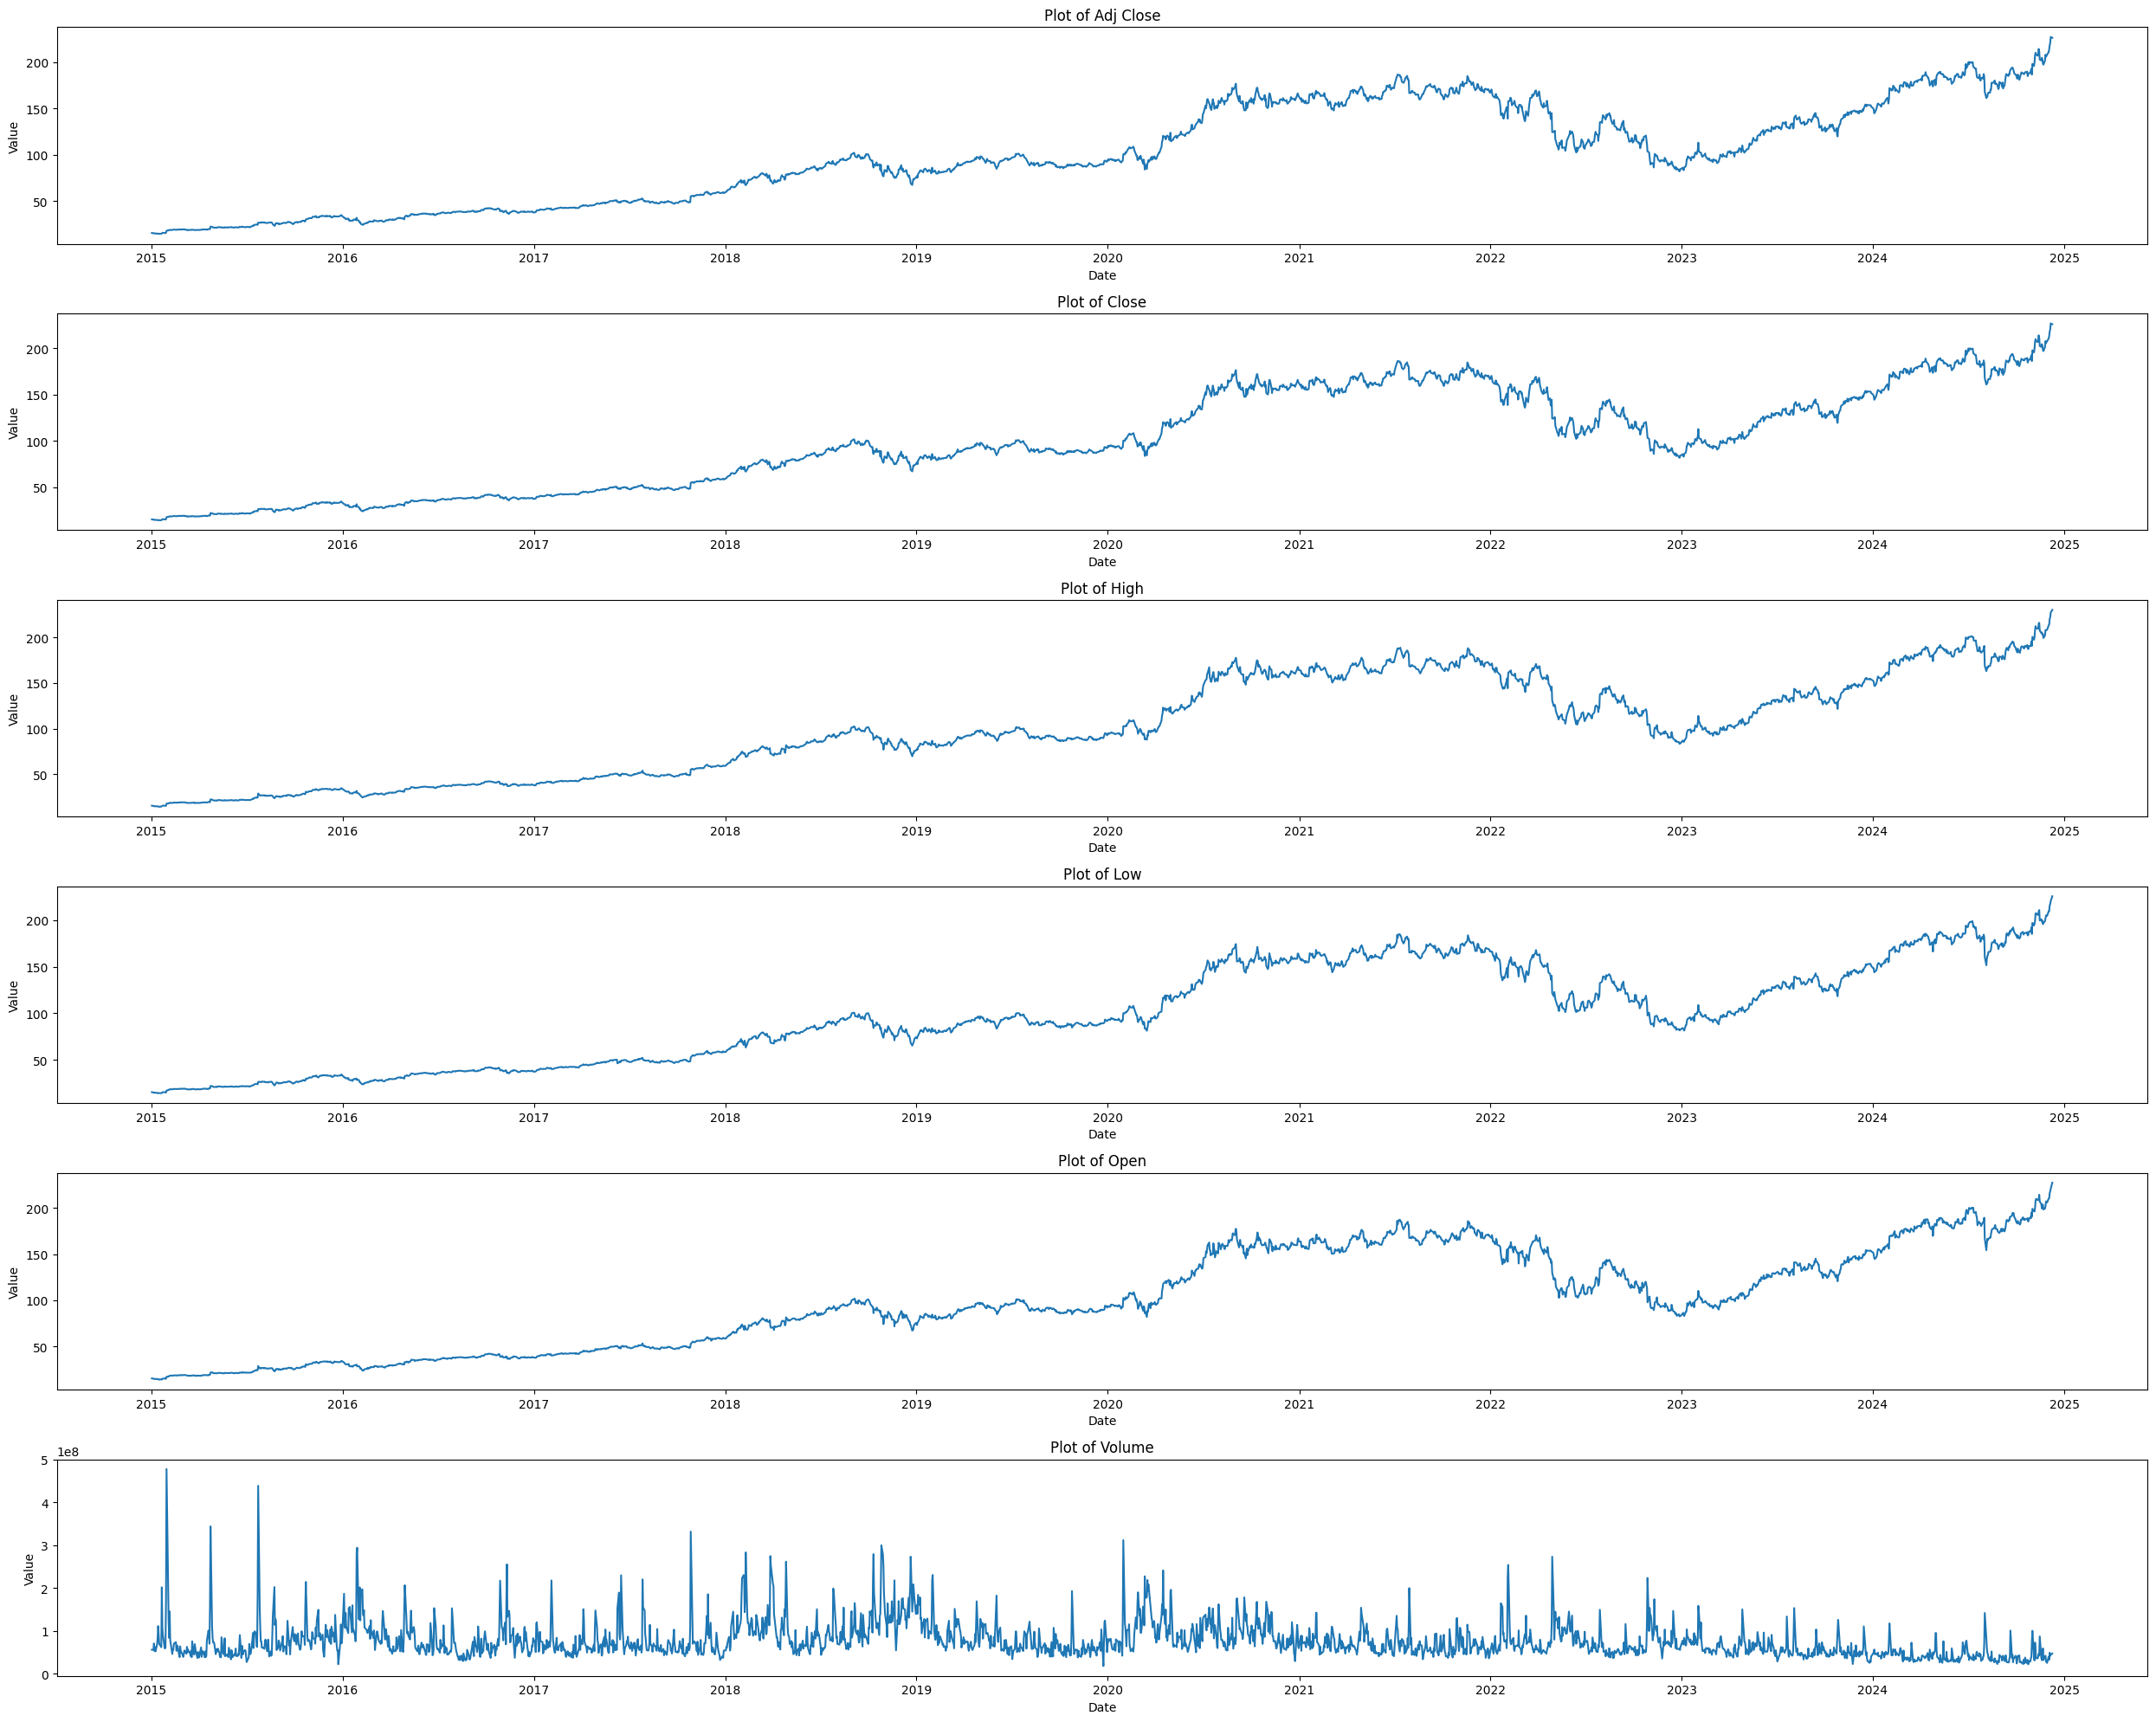

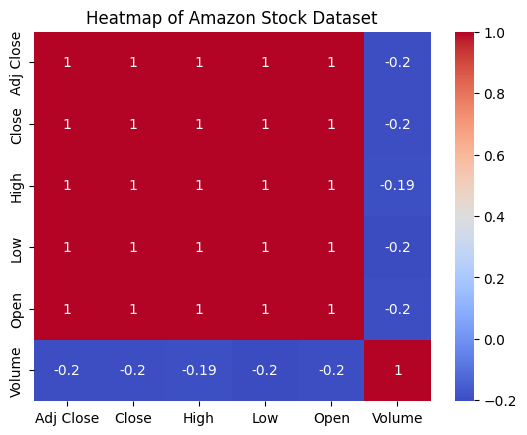

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_plots(df):
    # Plot general plots for this dataset
    print("Generic information about the given dataset: \n")
    print(df.info())

    print("General Statistics about the given dataset: \n")
    print(df.describe())

    fig = plt.figure(figsize=[25,20])

    date = df.index
    columns = df.columns.tolist()
    for i in range(len(df.columns)):
        fig.add_subplot(6, 1, i+1)
        plt.plot(date, df.iloc[:, i], label=columns[i])
        plt.title("Plot of " + columns[i])
        plt.xlabel("Date")
        plt.ylabel("Value")
    fig.tight_layout()

    plt.show()

def plot_heapmap(df):
    
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Heatmap of Amazon Stock Dataset')
    plt.show()


plot_plots(df)
plot_heapmap(df)


In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def build_and_train_lstm(X_train, y_train, epochs=20, batch_size=32):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

def evaluate_and_plot(model, X_test, y_test, scaler, data_index):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    plt.figure(figsize=(12, 6))
    plt.plot(data_index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price', color='blue')
    plt.plot(data_index[-len(predictions):], predictions, label='Predicted Price', color='red')
    plt.title('Actual vs Predicted Prices')
    plt.legend()
    plt.show()
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions))
    print(f"Root Mean Squared Error (RMSE): {rmse}")

def main(file_path):
    data = preprocess_raw_dataset(file_path)
    plot_plots(data)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']].values)
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    model = build_and_train_lstm(X_train, y_train)
    evaluate_and_plot(model, X_test, y_test, scaler, data.index)

Check if NaN exist within the data: 
 False
Generic information about the given dataset: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2015-01-02 to 2024-12-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2501 non-null   float64
 1   Close      2501 non-null   float64
 2   High       2501 non-null   float64
 3   Low        2501 non-null   float64
 4   Open       2501 non-null   float64
 5   Volume     2501 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 136.8 KB
None
General Statistics about the given dataset: 

         Adj Close        Close         High          Low         Open  \
count  2501.000000  2501.000000  2501.000000  2501.000000  2501.000000   
mean    100.484731   100.484731   101.649652    99.262112   100.505960   
std      53.463575    53.463575    54.103002    52.818208    53.484189   
min      14.347500    14.347500    14.539500    14.262500    14.31

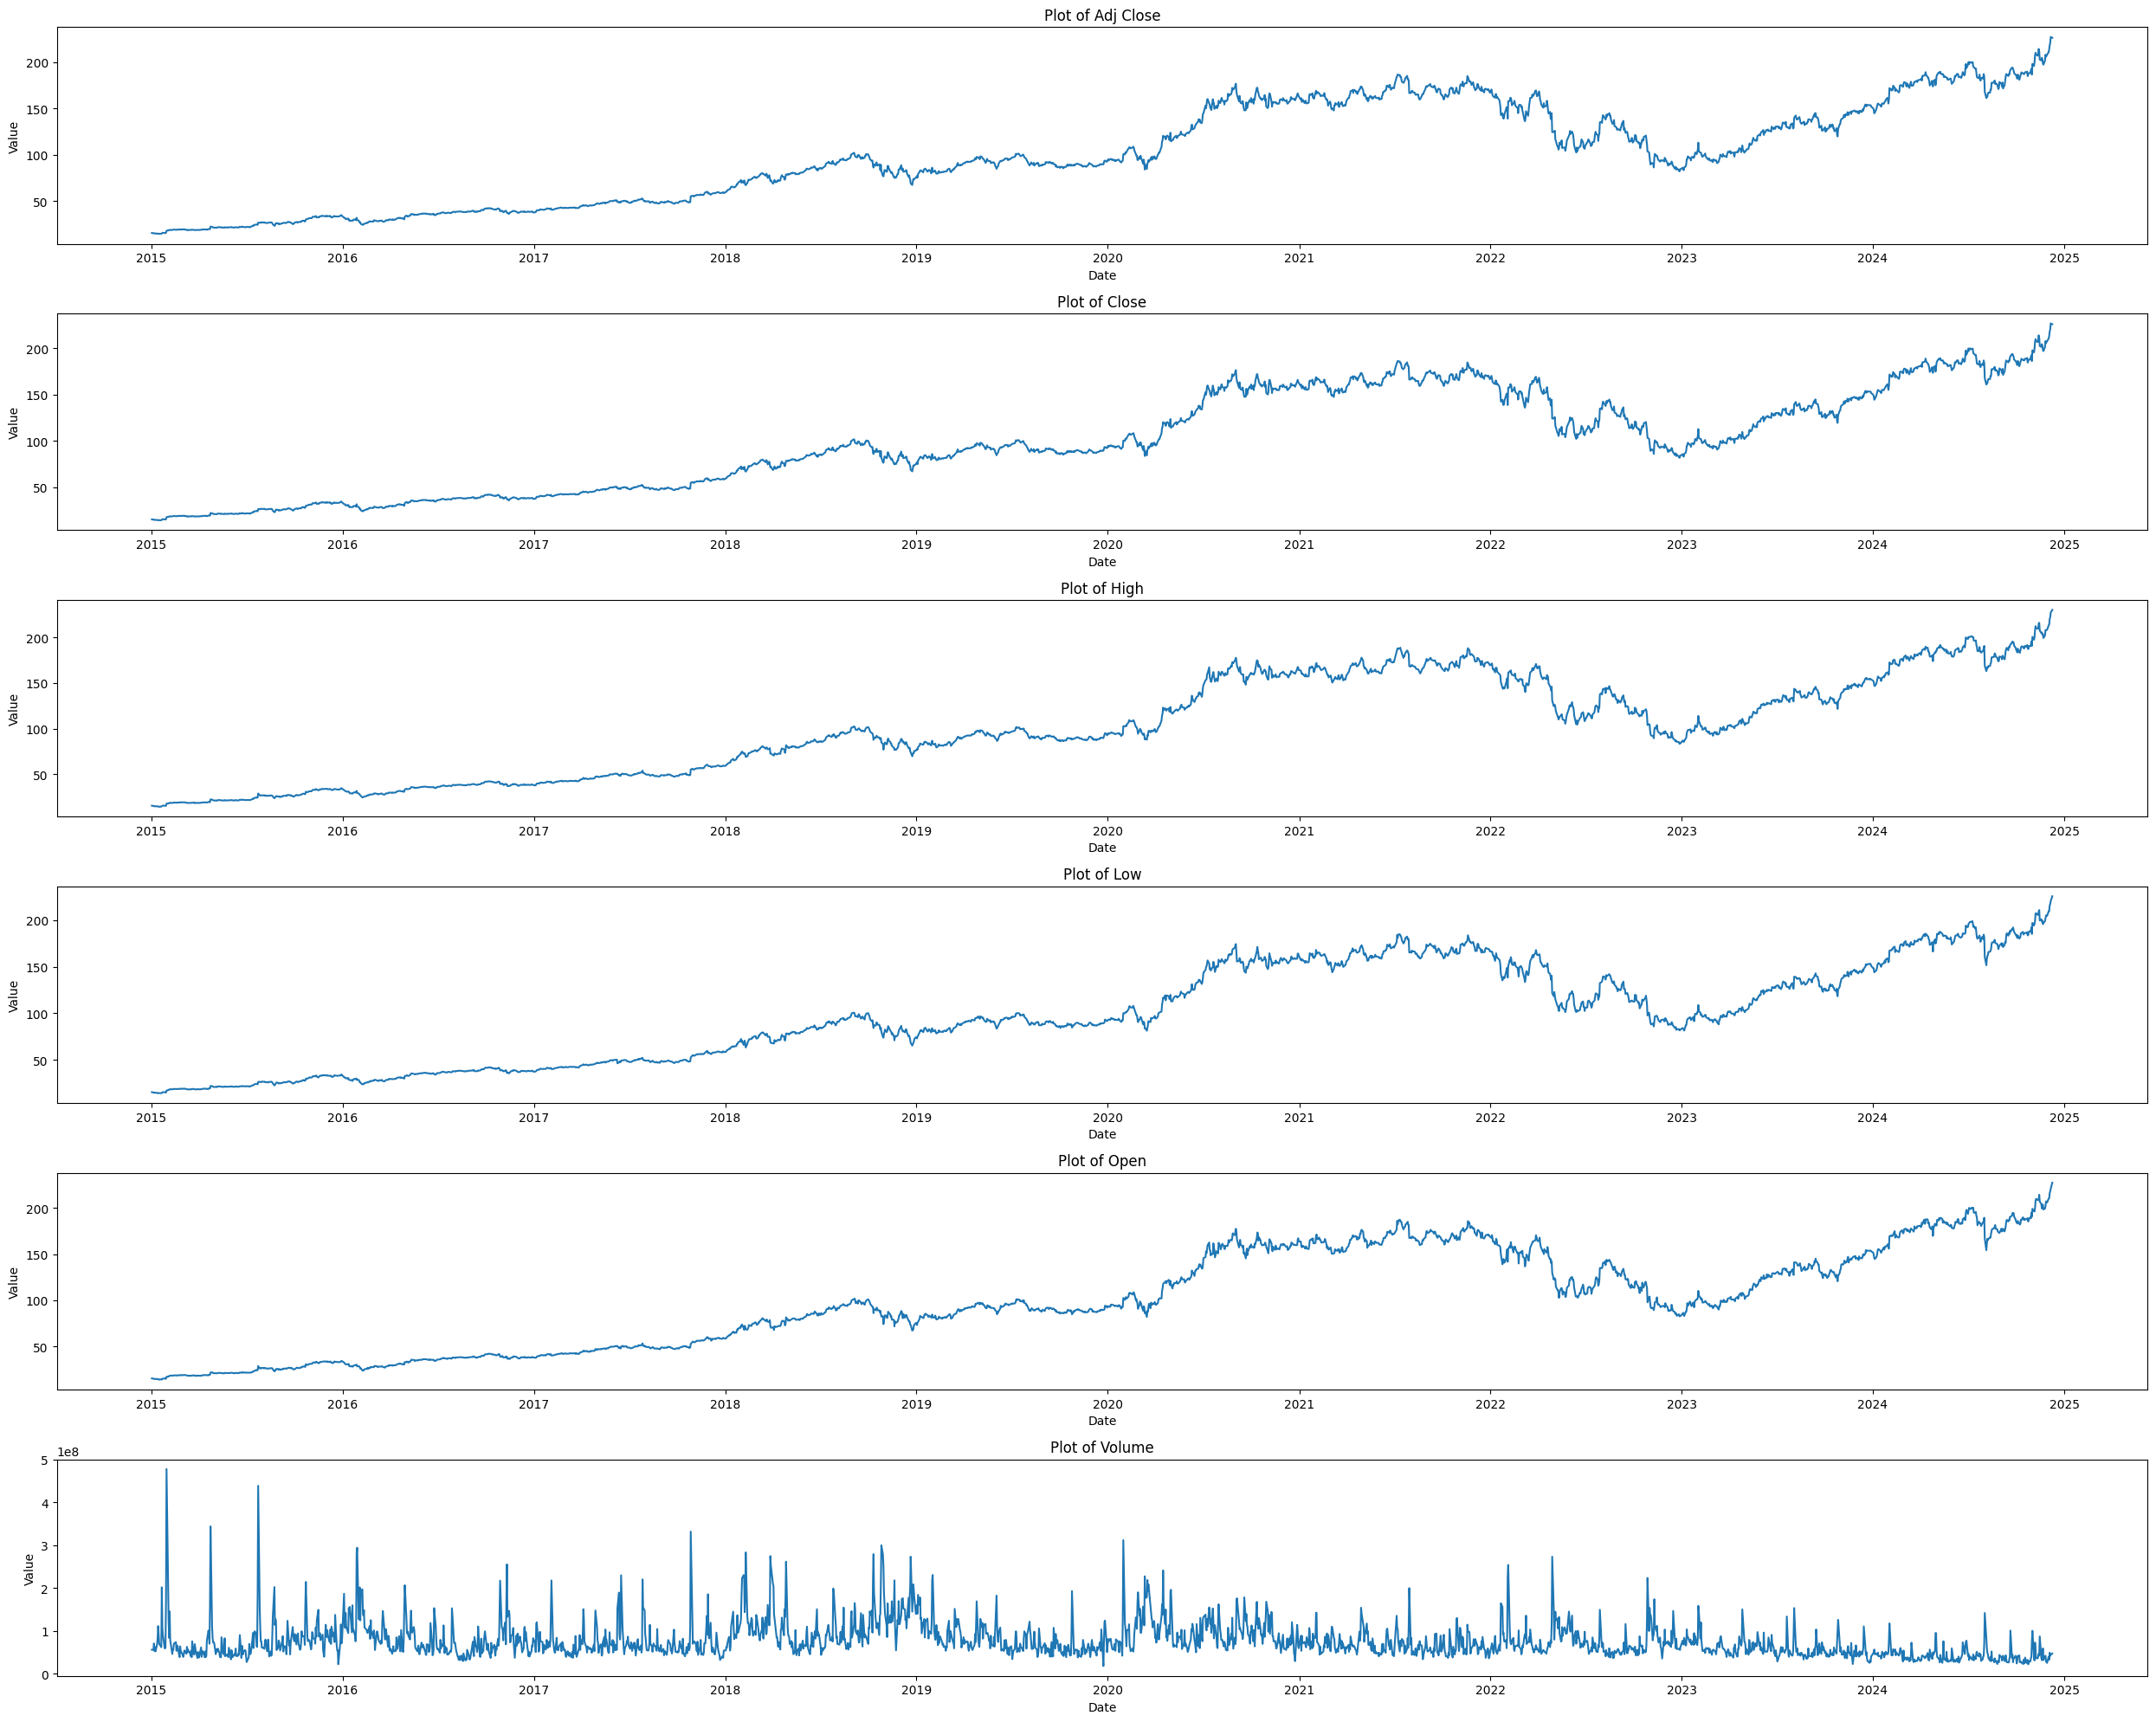

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0481
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0026
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0023
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0019
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0021
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0019
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0020
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0018
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0016
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0017
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0017
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0015
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0014
Epoch 15/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0015
Epoc

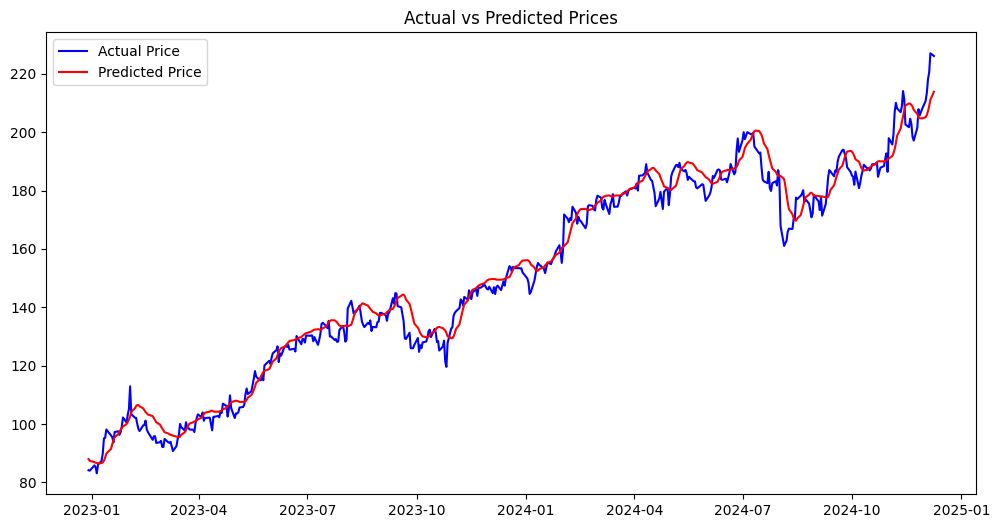

Root Mean Squared Error (RMSE): 5.1382082177115755


In [5]:
main(file_path=file_path)